# Climate Analysis
Now that the data is cleaned and packaged in an SQLite database, we will perform some basic climate analyses to explore and understand the data.

This process will allow us to prototype some of the functions and queries that the final climate app will use to query and serve the data to the user.

## Bringing the Data Into Python
We will use SQLAlchemy to bring the data back out of the database, and reflect the database schema in terms of Python classes. This will allow us to easily deal with query results as objects.

SQLAlchemy's `automap_base()` will allow us to do this very easily.

To more easily aggregate and visualize the data, we will then transform the query results into PANDAS dataframes.

### Dependencies

In [1]:
import pandas as pd
import datetime as dt

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

### Connecting to the Database
Here we supply the database url to create an engine object, and use the `.connect()` method to initiate the connection.

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')
conn = engine.connect()

### Reflecting the Database Schema
This step reflects the database schema in terms of Python classes, so we can work with query results in terms of Python class objects.

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
# check reflected table names
Base.classes.keys()

['hawaii_measurements', 'hawaii_stations']

In [5]:
# create references to reflected tables to use during query
Station = Base.classes.hawaii_stations
Measurement = Base.classes.hawaii_measurements

### Opening a Session and Querying Database
Here we begin a session to query the database, using our configured `engine`.

Using `session`'s `.query()` method will allow us to query the database in a Pythonic way, with SQLAlchemy emitting the required SQL, and returning the data as Python objects.

Check [SQLAlchemy's ORM Tutorial: Querying](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html#querying) for more information on how to use `.query()`.

In [6]:
session = Session(engine)

In [7]:
# query for first row in hawaii_measurements table to look at data structure
first_row = session.query(Measurement).first()

In [8]:
# look at returned object attributes using __dict__
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1166f4160>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

## Precipitation
To understand the rainfall patterns in Hawaii better, let's design a query to pull the last 12 months of precipitation data from the database, then make a bar graph to visualize it.

Because the data was collected more than a year ago, we will first find the last date in the database, then go 12 months back from that.

### Finding Last Date in Database
Here we use sqlalchemy's `func.max()` to find the latest date in the database

In [9]:
# import func to use func.max() on date column
from sqlalchemy import func
# .scalar() extracts first element of first result
last_db_date = session.query(func.max(Measurement.date)).scalar()
print("The most recent date in the database is: ", last_db_date)

The most recent date in the database is:  2017-08-23


In [10]:
# convert query result to datetime object to perform time math
last_datetime = dt.datetime.strptime(last_db_date, '%Y-%m-%d')
year_ago_datetime = last_datetime - dt.timedelta(days=365)
print("The date one year before the most recent date in the database is: ", year_ago_datetime.strftime('%Y-%m-%d'))

The date one year before the most recent date in the database is:  2016-08-23


### Querying for 12 Months of Precipitation Data
Here we pass in our start date, `year_ago_datetime`, into the filter method to get back only 12 months of data

In [11]:
# extracting relevant data from date, precipitation columns from hawaii_measurements table
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_datetime).all()
#stat = pd.DataFrame(session.query(Station).all())

### Loading Query Results into a PANDAS DataFrame
The results array can be easily transformed to a dataframe after query.

Because there are multiple precipitation measurements for any given date (remember, 9 stations reporting), the data will need to be grouped and aggregated before plotting. I chose to take the average of precipitation measurements for each day, by grouping by date, then applying `.mean()` to return the desired dataframe.

In [83]:
# Transform results to dataframe
last_yr_prcp = pd.DataFrame(results)
last_yr_prcp.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [90]:
last_yr_prcp.date = pd.to_datetime(last_yr_prcp.date, format='%Y-%m-%d', errors='ignore')
last_yr_prcp.date.dtype

dtype('<M8[ns]')

In [91]:
# groupby date and aggregate by mean
agg_prcp = last_yr_prcp.groupby('date').mean()
agg_prcp.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [92]:
# check that we have one year of dates
print("Number of days represented in dataframe: ", len(agg_prcp.index))

Number of days represented in dataframe:  365


### Plot Precipitation
An interesting note. I first tried to plot the dataframe as is (using the index as X), but PANDAS made the plot with a too-dense set of x-tick labels. PANDAS is supposed to lower the resolution, only printing some x-tick labels, but I could not figure out why it wasn't doing this.

I decided instead to construct a date index by hand using `pd.date_range()`. Supplying this as the x-axis caused PANDAS to format the plot correctly, with x-tick labels of low density. Still trying to figure out what happened. It seems that it worked because PANDAS didn't like the datatype `dtype('<M8[ns]')` of the index column, but because the custom DateRange Index was of a different datatype, it worked. Funny.

<IPython.core.display.Javascript object>


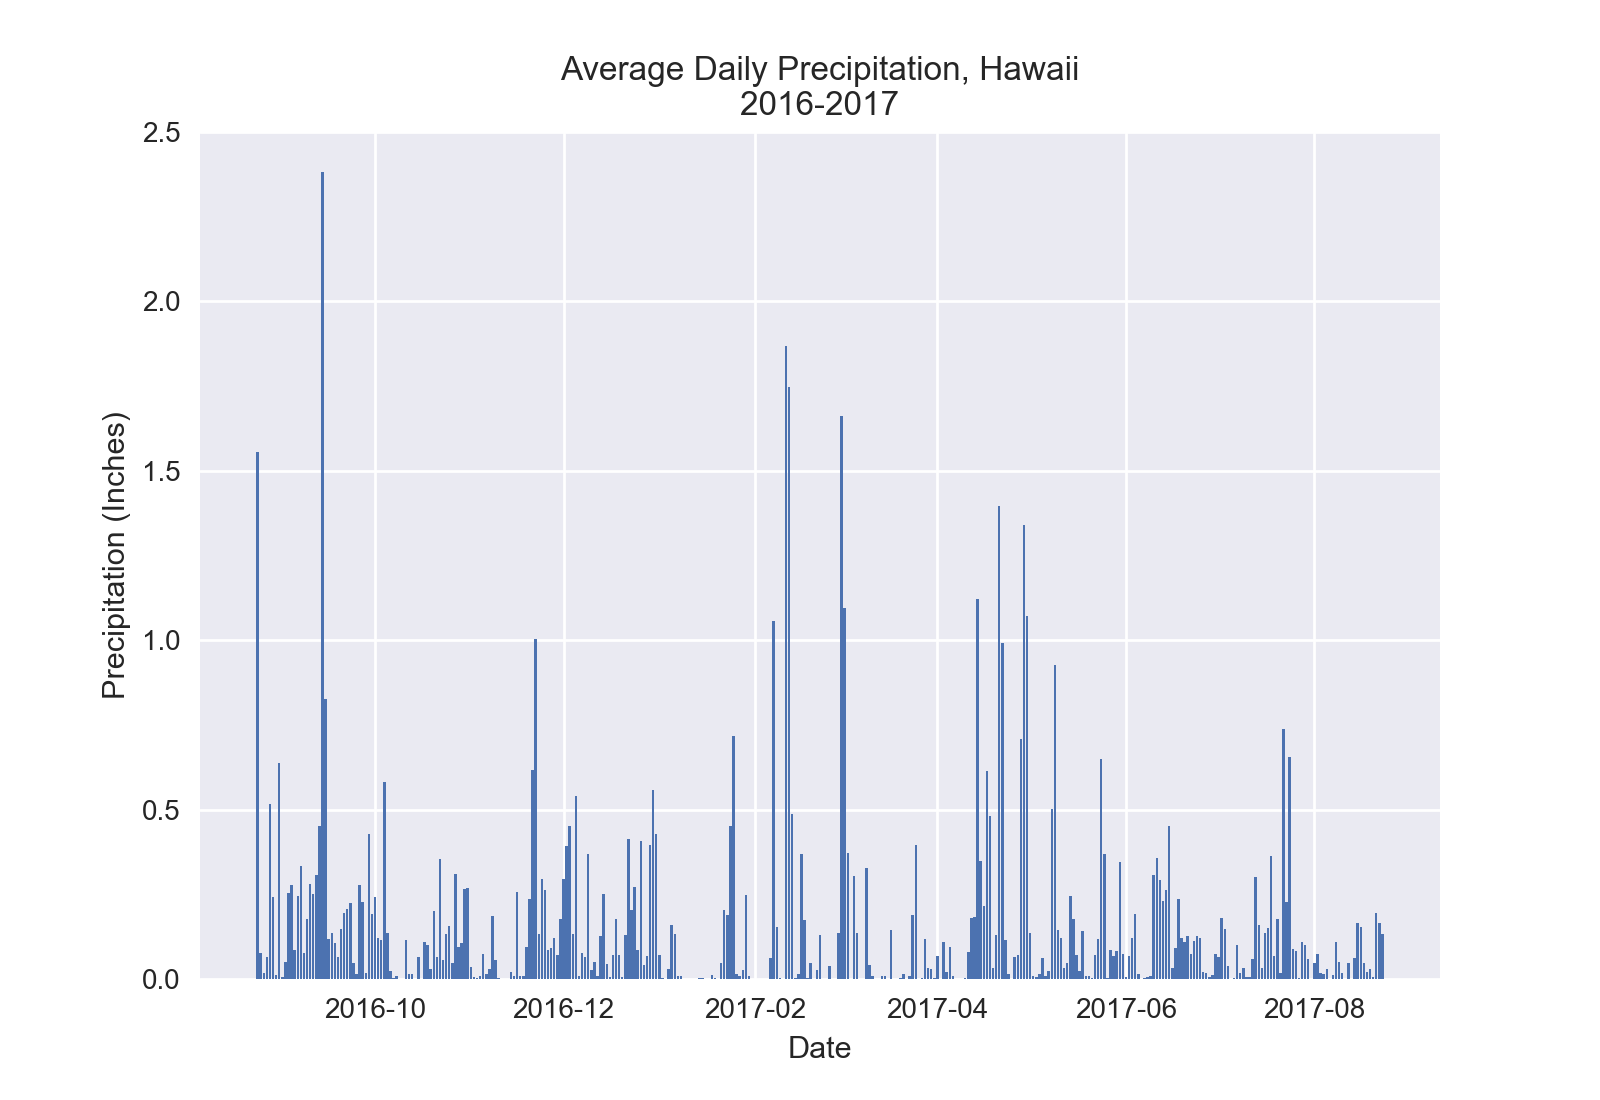

In [96]:
# construct date range identical to index
dates = pd.date_range('2016-08-24', '2017-08-23', freq='D')
# plot bar graph using date range
plt.bar(dates, agg_prcp.prcp)
plt.title('Average Daily Precipitation, Hawaii\n2016-2017')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.show()

As we can see here, average rainfall across the island of Hawaii is all over the place. Drier periods seem to occur in November, mid-January, late March, and July. Wetter periods seem to occur in September, February, and May.

## Station Analysis

In [ ]:
first_row = session.query(Station).first()

In [ ]:
first_row.__dict__

In [ ]:
all_stations = session.query(Station).all()

In [ ]:
len(all_stations)

There are 9 stations in total.

In [ ]:
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1290f94e0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [ ]:
all_meas = pd.DataFrame(session.query(Measurement.date, Measurement.id, Measurement.prcp, Measurement.station, Measurement.tobs).all())

In [ ]:
all_stat = pd.DataFrame(session.query(Station.elevation, Station.id, Station.latitude, Station.longitude, Station.name, Station.station).all())

In [ ]:
all_meas.head()

In [ ]:
all_stat.head(15)

In [ ]:
grouped = all_meas.groupby('station').id.count()

In [ ]:
groups_sorted = grouped.sort_values(ascending=False)

In [ ]:
groups_sorted.head(10)

Station USC00519281, Waihe'e has the highest number of observations, at 2772.

In [ ]:
just_waihee = all_meas[all_meas.station == 'USC00519281']

In [ ]:
just_waihee.tobs.hist(bins=12)
plt.xlabel('Degrees Farenheit')
plt.ylabel('Frequency')
plt.title('Frequency of Waihee Temperature Observations')
plt.show()

### Temperature Analysis

In [ ]:
all_meas.date.dtype

In [ ]:
all_meas.head()

Need to change date to int to make it filterable:

In [ ]:
new_all_meas = pd.DataFrame()
for index, row in all_meas.iterrows():
    parsed = row[0].replace('-', '')
    new_all_meas.set_value(index, 'date', parsed)
    new_all_meas.set_value(index, 'prcp', row[2])
    new_all_meas.set_value(index, 'id', row[1])
    new_all_meas.set_value(index, 'station', row[3])
    new_all_meas.set_value(index, 'tobs', row[4])

In [ ]:
new_all_meas['date'] = new_all_meas['date'].astype(int)

In [ ]:
new_all_meas.head()

In [ ]:
new_all_meas.date.dtype

In [ ]:
def calc_temps(start_date, end_date):
    parsed_start = int(start_date.replace('-', ''))
    parsed_end = int(end_date.replace('-', ''))
    subset_meas = new_all_meas[(new_all_meas.date >= parsed_start) & (new_all_meas.date <= parsed_end)]
    maxtemp = subset_meas.tobs.max()
    mintemp = subset_meas.tobs.min()
    avgtemp = subset_meas.tobs.mean()
    print('For date range selected, the:\nMax temp is: ', maxtemp, '\nMin temp is: ', mintemp, '\nAverage temp is: ', avgtemp)
    return maxtemp, mintemp, avgtemp

In [ ]:
maxtemp, mintemp, avgtemp = calc_temps('2011-01-05', '2011-01-27')

In [ ]:
plt.bar(0, avgtemp, yerr=(maxtemp - mintemp))
plt.ylabel('Degrees Farenheit')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.title('Average Temperature Over Trip Duration')
plt.show()

In [ ]:
adict = new_all_meas[['date', 'prcp']].set_index('date').to_dict()

In [ ]:
adict

In [ ]:
anotherdict = all_stat.set_index('id').to_dict(orient='index')

In [ ]:
anotherdict